In [1]:
import pandas as pd
import numpy as np
# import pylab as py
import matplotlib.pyplot as plt
from collections import Counter
import re


from statsmodels.tsa.arima_model import ARIMA 
from statsmodels.tsa.holtwinters import ExponentialSmoothing, SimpleExpSmoothing, Holt 
from sklearn.metrics import mean_squared_error
import time
%matplotlib inline 

In [177]:
df= pd.read_csv('data/coinbaseUSD_1-min_data_2014-12-01_to_2019-01-09.csv')

In [178]:
df.head(2)

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,1417411980,300.0,300.0,300.0,300.0,0.01,3.0,300.0
1,1417412040,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [179]:
df['date']= pd.to_datetime(df.Timestamp,unit='s') 

In [180]:
df.head(10) #still by minute? 

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,date
0,1417411980,300.0,300.0,300.0,300.0,0.01,3.0,300.0,2014-12-01 05:33:00
1,1417412040,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2014-12-01 05:34:00
2,1417412100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2014-12-01 05:35:00
3,1417412160,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2014-12-01 05:36:00
4,1417412220,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2014-12-01 05:37:00
5,1417412280,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2014-12-01 05:38:00
6,1417412340,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2014-12-01 05:39:00
7,1417412400,300.0,300.0,300.0,300.0,0.01,3.0,300.0,2014-12-01 05:40:00
8,1417412460,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2014-12-01 05:41:00
9,1417412520,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2014-12-01 05:42:00


In [181]:
df['date']=df.date.dt.date

In [182]:
df.head(2)

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,date
0,1417411980,300.0,300.0,300.0,300.0,0.01,3.0,300.0,2014-12-01
1,1417412040,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2014-12-01


In [183]:
df.dropna(inplace=True)

In [184]:
df.drop('Timestamp', 1, inplace=True)

In [185]:
df.dropna(inplace=True)

In [186]:
df = df.groupby('date').Close.mean().reset_index() #get daily data 

In [187]:
df.head(2)

,date,Close
0,2014-12-01,335.000000
1,2014-12-02,377.857143


In [188]:
df['Close_log']=np.log(df.Close)

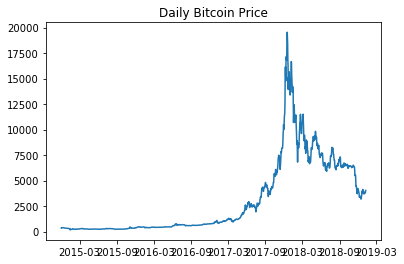

In [109]:
ts= df.Close
ts.index=df.date 
plt.plot(ts)
plt.title('Daily Bitcoin Price')

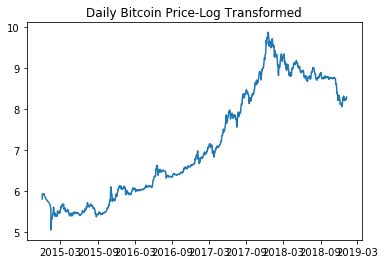

In [110]:
ts_log = np.log(df.Close)
ts_log.index=df.date
ts_log= ts_log[ts_log> 0]
plt.plot(ts_log)
plt.title('Daily Bitcoin Price-Log Transformed')

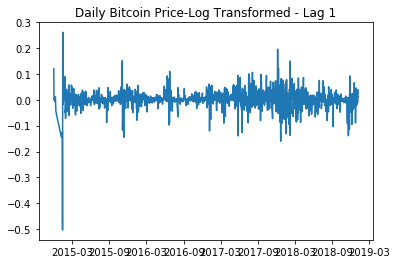

In [112]:
ts_log_diff = ts_log - ts_log.shift()
plt.plot(ts_log_diff)
plt.title('Daily Bitcoin Price-Log Transformed - Lag 1')

In [14]:
df.dropna(inplace=True)

In [15]:
df= df[~df.isin(['NaN']).any(axis=1)]

### Exp Smoothing

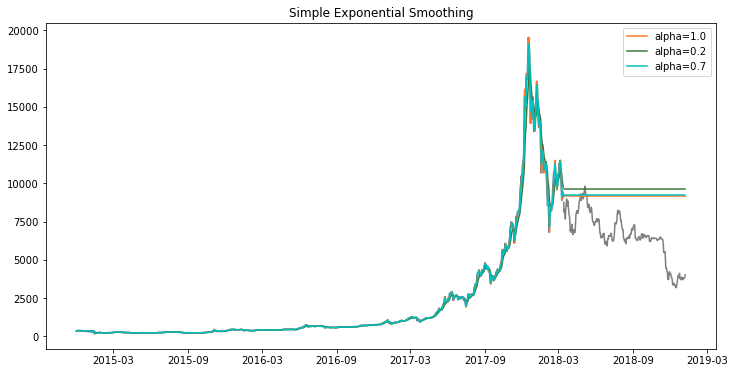

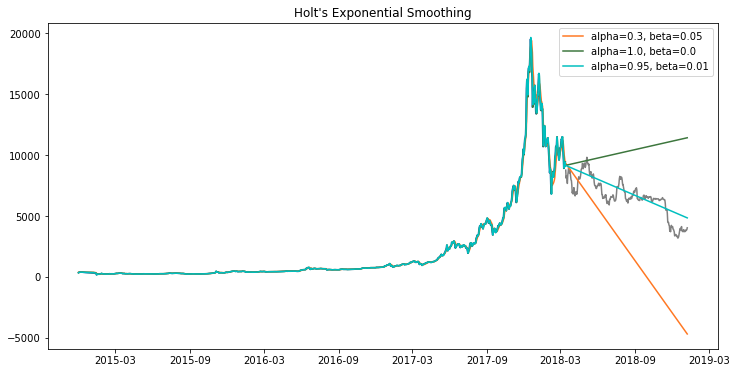

In [161]:
#exp smoothing
df2 = df[['date','Close']].set_index('date')
train = df2.iloc[:-300, :]
test = df2.iloc[-300:, :]

train.index = pd.to_datetime(train.index)
test.index = pd.to_datetime(test.index)

pred = test.copy()

model = SimpleExpSmoothing(np.asarray(train['Close']))
model._index = pd.to_datetime(train.index)

fit1 = model.fit()
pred1 = fit1.forecast(299)
fit2 = model.fit(smoothing_level=.2)
pred2 = fit2.forecast(299)
fit3 = model.fit(smoothing_level=0.7)
pred3 = fit3.forecast(299)


fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(train.index, train.values)
ax.plot(test.index, test.values, color="gray")
for p, f, c in zip((pred1, pred2, pred3),(fit1, fit2, fit3),('#ff7823','#3c763d','c')):
    ax.plot(train.index, f.fittedvalues, color=c)
    ax.plot(test.index, p, label="alpha="+str(f.params['smoothing_level'])[:3], color=c)
plt.title("Simple Exponential Smoothing")    
plt.legend();
    
model = Holt(np.asarray(train['Close']))
model._index = pd.to_datetime(train.index)

fit1 = model.fit(smoothing_level=.3, smoothing_slope=.05)
pred1 = fit1.forecast(299)
fit2 = model.fit(optimized=True)
pred2 = fit2.forecast(299)
fit3 = model.fit(smoothing_level=.95, smoothing_slope=.015)
pred3 = fit3.forecast(299)

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(train.index, train.values)
ax.plot(test.index, test.values, color="gray")
for p, f, c in zip((pred1, pred2, pred3),(fit1, fit2, fit3),('#ff7823','#3c763d','c')):
    ax.plot(train.index, f.fittedvalues, color=c)
    ax.plot(test.index, p, label="alpha="+str(f.params['smoothing_level'])[:4]+", beta="+str(f.params['smoothing_slope'])[:4], color=c)
plt.title("Holt's Exponential Smoothing")
plt.legend();

### Holt's exp smoothing with alpha 0.95 and beta 0.01 capture some trend....

In [18]:
df['Close_log']=np.log(df.Close)
df2 = df[['date','Close_log']].set_index('date') 

In [173]:
df2.head(2)

,Close_log
date,
2014-12-01,5.814131
2014-12-02,5.934516


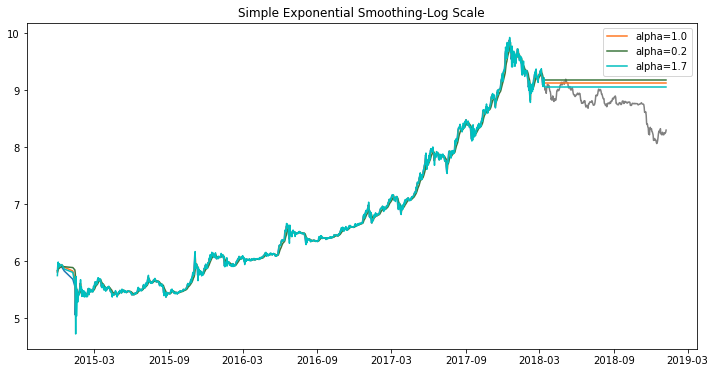

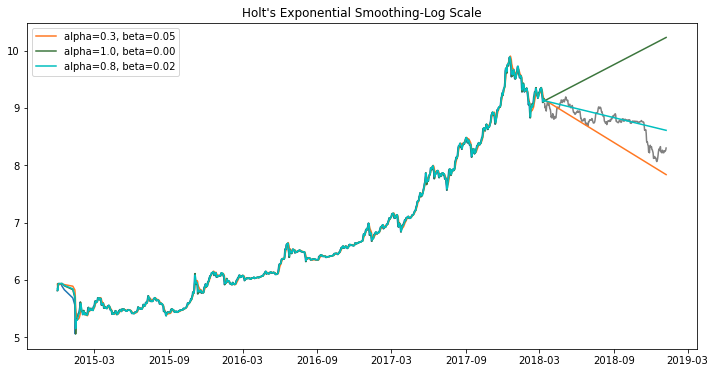

In [177]:
#exp smoothing in log scale 


df2 = df[['date','Close_log']].set_index('date')
train = df2.iloc[:-300, :]
test = df2.iloc[-300:, :]

train.index = pd.to_datetime(train.index)
test.index = pd.to_datetime(test.index)

pred = test.copy()

model = SimpleExpSmoothing(np.asarray(train['Close_log']))
model._index = pd.to_datetime(train.index)

fit1 = model.fit()
pred1 = fit1.forecast(299)
fit2 = model.fit(smoothing_level=.2)
pred2 = fit2.forecast(299)
fit3 = model.fit(smoothing_level=1.7)
pred3 = fit3.forecast(299)


fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(train.index, train.values)
ax.plot(test.index, test.values, color="gray")
for p, f, c in zip((pred1, pred2, pred3),(fit1, fit2, fit3),('#ff7823','#3c763d','c')):
    ax.plot(train.index, f.fittedvalues, color=c)
    ax.plot(test.index, p, label="alpha="+str(f.params['smoothing_level'])[:3], color=c)
plt.title("Simple Exponential Smoothing-Log Scale")    
plt.legend();
    
model = Holt(np.asarray(train['Close_log']))
model._index = pd.to_datetime(train.index)

fit1 = model.fit(smoothing_level=.3, smoothing_slope=.05)
pred1 = fit1.forecast(299)
fit2 = model.fit(optimized=True)
pred2 = fit2.forecast(299)
fit3 = model.fit(smoothing_level=.8, smoothing_slope=.02)
pred3 = fit3.forecast(299)

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(train.index, train.values)
ax.plot(test.index, test.values, color="gray")
for p, f, c in zip((pred1, pred2, pred3),(fit1, fit2, fit3),('#ff7823','#3c763d','c')):
    ax.plot(train.index, f.fittedvalues, color=c)
    ax.plot(test.index, p, label="alpha="+str(f.params['smoothing_level'])[:4]+", beta="+str(f.params['smoothing_slope'])[:4], color=c)
plt.title("Holt's Exponential Smoothing-Log Scale")
plt.legend();

### ARIMA: 
### Use this as reference as the y_pred is following y_test in this example: 
##### https://towardsdatascience.com/bitcoin-price-prediction-using-time-series-forecasting-9f468f7174d3 

### LSTM 

In [16]:
from keras.models import Sequential, Model
from keras.layers.embeddings import Embedding
from keras.layers import Input, Activation, Dense, Permute, Dropout, TimeDistributed
from keras.layers import add, dot, concatenate
from keras.layers import LSTM
from keras.utils.data_utils import get_file
from keras.preprocessing.sequence import pad_sequences
from keras import optimizers


from sklearn.metrics import mean_squared_error

/Users/koyuki.nakamori/anaconda/lib/python2.7/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [237]:
for i in range(1, 31): 
    df2['lag_{}'.format(i)]=df2.Close_log.shift(i)

In [238]:
df2.fillna(0, inplace=True)

In [239]:
df2.tail(10)

,Close_log,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,...,lag_21,lag_22,lag_23,lag_24,lag_25,lag_26,lag_27,lag_28,lag_29,lag_30
1455,8.262088,8.216419,8.220842,8.236200,8.235826,8.325119,8.288715,8.256461,8.287423,8.274981,...,8.126959,8.119277,8.214746,8.243607,8.269996,8.275271,8.324122,8.313726,8.312849,8.348763
1456,8.239852,8.262088,8.216419,8.220842,8.236200,8.235826,8.325119,8.288715,8.256461,8.287423,...,8.151535,8.126959,8.119277,8.214746,8.243607,8.269996,8.275271,8.324122,8.313726,8.312849
1457,8.231270,8.239852,8.262088,8.216419,8.220842,8.236200,8.235826,8.325119,8.288715,8.256461,...,8.151839,8.151535,8.126959,8.119277,8.214746,8.243607,8.269996,8.275271,8.324122,8.313726
1458,8.216269,8.231270,8.239852,8.262088,8.216419,8.220842,8.236200,8.235826,8.325119,8.288715,...,8.121323,8.151839,8.151535,8.126959,8.119277,8.214746,8.243607,8.269996,8.275271,8.324122
1459,8.248846,8.216269,8.231270,8.239852,8.262088,8.216419,8.220842,8.236200,8.235826,8.325119,...,8.130489,8.121323,8.151839,8.151535,8.126959,8.119277,8.214746,8.243607,8.269996,8.275271
1460,8.250600,8.248846,8.216269,8.231270,8.239852,8.262088,8.216419,8.220842,8.236200,8.235826,...,8.119857,8.130489,8.121323,8.151839,8.151535,8.126959,8.119277,8.214746,8.243607,8.269996
1461,8.238908,8.250600,8.248846,8.216269,8.231270,8.239852,8.262088,8.216419,8.220842,8.236200,...,8.081523,8.119857,8.130489,8.121323,8.151839,8.151535,8.126959,8.119277,8.214746,8.243607
1462,8.251823,8.238908,8.250600,8.248846,8.216269,8.231270,8.239852,8.262088,8.216419,8.220842,...,8.064587,8.081523,8.119857,8.130489,8.121323,8.151839,8.151535,8.126959,8.119277,8.214746
1463,8.262159,8.251823,8.238908,8.250600,8.248846,8.216269,8.231270,8.239852,8.262088,8.216419,...,8.076365,8.064587,8.081523,8.119857,8.130489,8.121323,8.151839,8.151535,8.126959,8.119277
1464,8.300303,8.262159,8.251823,8.238908,8.250600,8.248846,8.216269,8.231270,8.239852,8.262088,...,8.111617,8.076365,8.064587,8.081523,8.119857,8.130489,8.121323,8.151839,8.151535,8.126959


In [254]:
X=df2.iloc[:, 1:].values
y=df2.Close_log.values

In [255]:
X_train, X_test= X[:-50, : ], X[-50:, : ]
y_train,y_test=y[:-50], y[-50: ]

In [242]:
# from sklearn.preprocessing import MinMaxScaler
# min_max_scaler = MinMaxScaler() 
# X_train = min_max_scaler.fit_transform(pd.DataFrame(X_train))

In [243]:
# X_test= min_max_scaler.transform(pd.DataFrame(X_test))

In [256]:
X_train.shape

(1415, 30)

In [257]:
X_train= X_train.reshape((1415, 30, 1))
X_test= X_test.reshape ((50, 30, 1 ))

In [258]:
model = Sequential()
model.add(LSTM(512, return_sequences=True, input_shape=(30, 1), activation='linear'))
model.add(Dropout(0.2))
model.add(LSTM(512, return_sequences=True, activation='linear'))
model.add(Dropout(0.2))
model.add(LSTM(512, activation='linear'))
model.add(Dropout(0.2))
model.add(Dense(1))
model.add(Activation('linear'))
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_47 (LSTM)               (None, 30, 512)           1052672   
_________________________________________________________________
dropout_37 (Dropout)         (None, 30, 512)           0         
_________________________________________________________________
lstm_48 (LSTM)               (None, 30, 512)           2099200   
_________________________________________________________________
dropout_38 (Dropout)         (None, 30, 512)           0         
_________________________________________________________________
lstm_49 (LSTM)               (None, 512)               2099200   
_________________________________________________________________
dropout_39 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_22 (Dense)             (None, 1)                 513       
__________

Train on 1415 samples, validate on 50 samples
Epoch 1/10
1415/1415 [==============================] - 50s 35ms/step - loss: 206.5364 - mean_absolute_error: 7.8207 - val_loss: 44.8344 - val_mean_absolute_error: 6.6950
Epoch 2/10
1415/1415 [==============================] - 44s 31ms/step - loss: 18.6739 - mean_absolute_error: 3.8068 - val_loss: 0.0457 - val_mean_absolute_error: 0.1960
Epoch 3/10
1415/1415 [==============================] - 44s 31ms/step - loss: 0.9456 - mean_absolute_error: 0.6495 - val_loss: 0.0368 - val_mean_absolute_error: 0.1820
Epoch 4/10
1415/1415 [==============================] - 43s 30ms/step - loss: 0.6918 - mean_absolute_error: 0.5096 - val_loss: 0.1572 - val_mean_absolute_error: 0.3436
Epoch 5/10
1415/1415 [==============================] - 57s 40ms/step - loss: 0.6056 - mean_absolute_error: 0.4538 - val_loss: 0.1130 - val_mean_absolute_error: 0.2739
Epoch 6/10
1415/1415 [==============================] - 48s 34ms/step - loss: 0.5597 - mean_absolute_error: 0.

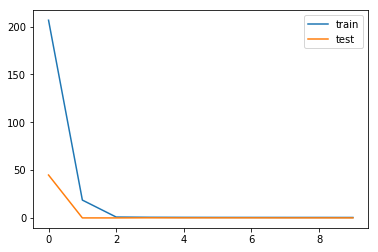

In [259]:
history = model.fit(X_train, y_train,
          batch_size=64, epochs=10,
          validation_data=(X_test, y_test))
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [261]:
y_pred= model.predict(X_test)

In [262]:
df.date[:-50].shape

(1415,)

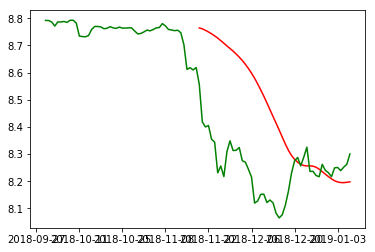

In [274]:
#plot 
plt.plot(df.date[-50:], y_pred, color='red')
#plt.plot(df.date[-50:], y_test, color='orange')
plt.plot(df.date[-100:], y[-100:], color='green')

In [ ]:
## kinda following the y_test

In [ ]:
### We can add not just previous closing but volumn/other metrics as well in the features 

In [264]:
rmse = np.sqrt(mean_squared_error(np.exp(y_test), np.exp(y_pred)))  #inverse transform 
rmse

1322.7371499226174

## I would also try facebooks-prophet 

#### https://medium.com/@sunnyday.james/bitcoin-predictive-price-modeling-with-facebooks-prophet-b66efd0169a0